## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import os

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Transform the Data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Load the Data

In [ ]:
# Load CIFAR 10 dataset with training and testing Components
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize a few images

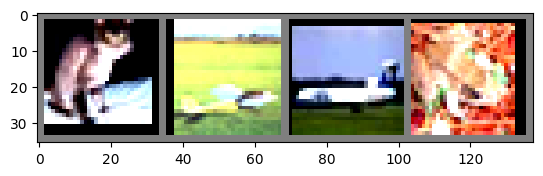

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


batch_size = 4

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

## Define ResNet Architecture

We have modified the architecture to reduce blocks in layers. The following modifications were made to ResNet 18 architecture found at https://github.com/kuangliu/pytorch-cifar. 

- Removed block with 512 filters  
- Dropout of 0.2 added
- SGD optimizer


In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2])

In [ ]:
net = ResNet18()

In [ ]:
## Move model to CUDA
net = net.to(device)

## Model Summary and Parameters
eters
We are checking total number of trainable params and visualizing the model summary

In [ ]:
summary(net, input_size = (3,32,32), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
total_trainable_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
print("Total Trainable Parameters: %d"%total_trainable_parameters)

Total Trainable Parameters: 2777674


Which is under 5 million :)

## Define Train and Test functions 

In [ ]:
# Training
def train(epoch):
    
    ## Setting the model in training mode
    net.train()
    
    ## Initialize Epoch loss and accuracy 
    train_loss = 0
    train_acc = 0 
    
    ## Number of correct examples
    correct = 0
    total = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        ## Movie inputs and targets to cuda
        inputs, targets = inputs.to(device), targets.to(device)

        ## Set gradients to zero after every batch
        optimizer.zero_grad()

        ## Get predictions
        outputs = net(inputs)

        ## Compute Loss
        loss = criterion(outputs, targets)

        ## Do backprop
        loss.backward()

        ## Update weights 
        optimizer.step()

        ## Add loss
        train_loss += loss.item()
        
        ## Computer Number of correct examples
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
    
    
    train_acc += 100.*correct/total


   
    
    return train_loss / len(trainloader) , train_acc

In [ ]:
def test(epoch):
    ## Setting models to evaluation mode
    net.eval()
    
    ## Initialize epoch loss and accuracy
    test_loss = 0
    test_acc = 0 

    ## Number of correct examples
    correct = 0
    total = 0


    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            ## Move inputs and targets to cuda

            inputs, targets = inputs.to(device), targets.to(device)

            ## Get predictions

            outputs = net(inputs)

            ## Compute Loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            ## Computer Accuracy 
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    test_acc = 100.*correct/total
    
    return test_loss / len(testloader) , test_acc

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Defining Loss function, optimizer and LR Scheduler

In [ ]:
LEARNING_RATE = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE,
                       weight_decay=5e-4 , momentum = 0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

criterion = criterion.to(device)

## Train the model


In [ ]:
EPOCHS = 120
best_testing_accuracy = 0 

## Define model history to store accuracy and losses

history = {}
history["accuracy"] = []
history["test_accuracy"] = []
history["loss"] = []
history["test_loss"] = []

In [ ]:
## First train for 120 

for epoch in tqdm(range(EPOCHS)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  1%|          | 1/120 [00:46<1:31:15, 46.01s/it]

Training Loss: 1.671 | Training Acc: 37.802% | Testing Loss: 1.618 | Testing Acc:42.530%


  2%|▏         | 2/120 [01:25<1:23:05, 42.25s/it]

Training Loss: 1.174 | Training Acc: 57.404% | Testing Loss: 1.214 | Testing Acc:57.700%


  2%|▎         | 3/120 [02:03<1:18:47, 40.41s/it]

Training Loss: 0.940 | Training Acc: 66.558% | Testing Loss: 1.009 | Testing Acc:66.560%


  3%|▎         | 4/120 [02:42<1:16:45, 39.70s/it]

Training Loss: 0.787 | Training Acc: 72.156% | Testing Loss: 0.828 | Testing Acc:71.990%


  4%|▍         | 5/120 [03:21<1:15:36, 39.45s/it]

Training Loss: 0.668 | Training Acc: 76.860% | Testing Loss: 0.804 | Testing Acc:72.320%


  5%|▌         | 6/120 [03:59<1:14:15, 39.08s/it]

Training Loss: 0.592 | Training Acc: 79.610% | Testing Loss: 0.755 | Testing Acc:73.860%


  6%|▌         | 7/120 [04:38<1:13:09, 38.85s/it]

Training Loss: 0.544 | Training Acc: 81.168% | Testing Loss: 0.743 | Testing Acc:75.600%


  7%|▋         | 8/120 [05:17<1:12:30, 38.84s/it]

Training Loss: 0.515 | Training Acc: 82.396% | Testing Loss: 0.563 | Testing Acc:80.710%


  8%|▊         | 9/120 [05:55<1:11:40, 38.74s/it]

Training Loss: 0.483 | Training Acc: 83.580% | Testing Loss: 0.603 | Testing Acc:80.100%


  8%|▊         | 10/120 [06:34<1:10:56, 38.70s/it]

Training Loss: 0.468 | Training Acc: 84.004% | Testing Loss: 0.626 | Testing Acc:79.210%


  9%|▉         | 11/120 [07:13<1:10:23, 38.75s/it]

Training Loss: 0.461 | Training Acc: 84.184% | Testing Loss: 0.624 | Testing Acc:79.720%


 10%|█         | 12/120 [07:51<1:09:34, 38.65s/it]

Training Loss: 0.434 | Training Acc: 85.280% | Testing Loss: 0.620 | Testing Acc:80.550%


 11%|█         | 13/120 [08:30<1:08:59, 38.69s/it]

Training Loss: 0.426 | Training Acc: 85.592% | Testing Loss: 0.563 | Testing Acc:80.790%


 12%|█▏        | 14/120 [09:08<1:08:12, 38.61s/it]

Training Loss: 0.414 | Training Acc: 85.924% | Testing Loss: 0.641 | Testing Acc:80.000%


 12%|█▎        | 15/120 [09:47<1:07:38, 38.66s/it]

Training Loss: 0.403 | Training Acc: 86.260% | Testing Loss: 0.465 | Testing Acc:84.550%


 13%|█▎        | 16/120 [10:25<1:06:55, 38.61s/it]

Training Loss: 0.397 | Training Acc: 86.440% | Testing Loss: 0.757 | Testing Acc:76.410%


 14%|█▍        | 17/120 [11:04<1:06:18, 38.63s/it]

Training Loss: 0.385 | Training Acc: 86.874% | Testing Loss: 0.560 | Testing Acc:81.130%


 15%|█▌        | 18/120 [11:43<1:06:02, 38.84s/it]

Training Loss: 0.384 | Training Acc: 86.926% | Testing Loss: 0.527 | Testing Acc:82.190%


 16%|█▌        | 19/120 [12:22<1:05:16, 38.78s/it]

Training Loss: 0.373 | Training Acc: 87.320% | Testing Loss: 0.603 | Testing Acc:80.650%


 17%|█▋        | 20/120 [13:01<1:04:40, 38.81s/it]

Training Loss: 0.373 | Training Acc: 87.162% | Testing Loss: 0.678 | Testing Acc:78.980%


 18%|█▊        | 21/120 [13:39<1:03:53, 38.72s/it]

Training Loss: 0.356 | Training Acc: 87.906% | Testing Loss: 0.579 | Testing Acc:80.970%


 18%|█▊        | 22/120 [14:19<1:03:28, 38.86s/it]

Training Loss: 0.359 | Training Acc: 87.800% | Testing Loss: 0.594 | Testing Acc:81.060%


 19%|█▉        | 23/120 [14:57<1:02:38, 38.74s/it]

Training Loss: 0.357 | Training Acc: 87.924% | Testing Loss: 0.669 | Testing Acc:78.930%


 20%|██        | 24/120 [15:36<1:01:50, 38.65s/it]

Training Loss: 0.348 | Training Acc: 87.994% | Testing Loss: 0.480 | Testing Acc:83.700%


 21%|██        | 25/120 [16:15<1:01:24, 38.79s/it]

Training Loss: 0.347 | Training Acc: 88.038% | Testing Loss: 0.479 | Testing Acc:84.050%


 22%|██▏       | 26/120 [16:53<1:00:32, 38.65s/it]

Training Loss: 0.345 | Training Acc: 88.122% | Testing Loss: 0.473 | Testing Acc:84.490%


 22%|██▎       | 27/120 [17:32<1:00:02, 38.73s/it]

Training Loss: 0.344 | Training Acc: 88.380% | Testing Loss: 0.536 | Testing Acc:82.180%


 23%|██▎       | 28/120 [18:10<59:02, 38.50s/it]  

Training Loss: 0.340 | Training Acc: 88.470% | Testing Loss: 0.688 | Testing Acc:79.470%


 24%|██▍       | 29/120 [18:48<58:17, 38.44s/it]

Training Loss: 0.335 | Training Acc: 88.478% | Testing Loss: 0.563 | Testing Acc:81.760%


 25%|██▌       | 30/120 [19:26<57:22, 38.25s/it]

Training Loss: 0.332 | Training Acc: 88.546% | Testing Loss: 0.518 | Testing Acc:82.640%


 26%|██▌       | 31/120 [20:04<56:30, 38.10s/it]

Training Loss: 0.337 | Training Acc: 88.548% | Testing Loss: 0.420 | Testing Acc:86.670%


 27%|██▋       | 32/120 [20:42<56:01, 38.20s/it]

Training Loss: 0.331 | Training Acc: 88.590% | Testing Loss: 0.496 | Testing Acc:83.520%


 28%|██▊       | 33/120 [21:20<55:18, 38.14s/it]

Training Loss: 0.320 | Training Acc: 88.982% | Testing Loss: 0.624 | Testing Acc:79.890%


 28%|██▊       | 34/120 [21:59<54:55, 38.32s/it]

Training Loss: 0.325 | Training Acc: 88.880% | Testing Loss: 0.539 | Testing Acc:82.270%


 29%|██▉       | 35/120 [22:37<54:08, 38.22s/it]

Training Loss: 0.325 | Training Acc: 88.952% | Testing Loss: 0.531 | Testing Acc:83.020%


 30%|███       | 36/120 [23:15<53:40, 38.34s/it]

Training Loss: 0.320 | Training Acc: 89.170% | Testing Loss: 0.535 | Testing Acc:83.130%


 31%|███       | 37/120 [23:54<52:58, 38.29s/it]

Training Loss: 0.316 | Training Acc: 89.362% | Testing Loss: 0.521 | Testing Acc:83.570%


 32%|███▏      | 38/120 [24:32<52:24, 38.35s/it]

Training Loss: 0.313 | Training Acc: 89.354% | Testing Loss: 0.578 | Testing Acc:82.660%


 32%|███▎      | 39/120 [25:11<52:02, 38.55s/it]

Training Loss: 0.311 | Training Acc: 89.386% | Testing Loss: 0.611 | Testing Acc:80.750%


 33%|███▎      | 40/120 [25:50<51:22, 38.53s/it]

Training Loss: 0.312 | Training Acc: 89.482% | Testing Loss: 0.455 | Testing Acc:84.880%


 34%|███▍      | 41/120 [26:29<50:53, 38.65s/it]

Training Loss: 0.310 | Training Acc: 89.420% | Testing Loss: 0.413 | Testing Acc:86.120%


 35%|███▌      | 42/120 [27:07<50:10, 38.60s/it]

Training Loss: 0.311 | Training Acc: 89.216% | Testing Loss: 0.519 | Testing Acc:83.070%


 36%|███▌      | 43/120 [27:46<49:34, 38.63s/it]

Training Loss: 0.302 | Training Acc: 89.600% | Testing Loss: 0.619 | Testing Acc:80.300%


 37%|███▋      | 44/120 [28:24<48:43, 38.46s/it]

Training Loss: 0.306 | Training Acc: 89.458% | Testing Loss: 0.588 | Testing Acc:80.840%


 38%|███▊      | 45/120 [29:02<47:52, 38.30s/it]

Training Loss: 0.298 | Training Acc: 89.856% | Testing Loss: 0.440 | Testing Acc:85.290%


 38%|███▊      | 46/120 [29:40<47:20, 38.39s/it]

Training Loss: 0.295 | Training Acc: 89.896% | Testing Loss: 0.472 | Testing Acc:85.250%


 39%|███▉      | 47/120 [30:18<46:25, 38.16s/it]

Training Loss: 0.298 | Training Acc: 89.704% | Testing Loss: 0.622 | Testing Acc:80.480%


 40%|████      | 48/120 [30:57<45:55, 38.28s/it]

Training Loss: 0.299 | Training Acc: 89.828% | Testing Loss: 0.566 | Testing Acc:82.000%


 41%|████      | 49/120 [31:34<45:06, 38.12s/it]

Training Loss: 0.293 | Training Acc: 89.992% | Testing Loss: 0.669 | Testing Acc:79.510%


 42%|████▏     | 50/120 [32:13<44:34, 38.20s/it]

Training Loss: 0.294 | Training Acc: 89.952% | Testing Loss: 0.598 | Testing Acc:81.440%


 42%|████▎     | 51/120 [32:51<43:49, 38.11s/it]

Training Loss: 0.292 | Training Acc: 89.988% | Testing Loss: 0.499 | Testing Acc:84.240%


 43%|████▎     | 52/120 [33:29<43:10, 38.10s/it]

Training Loss: 0.293 | Training Acc: 90.066% | Testing Loss: 0.489 | Testing Acc:84.320%


 44%|████▍     | 53/120 [34:07<42:42, 38.25s/it]

Training Loss: 0.284 | Training Acc: 90.352% | Testing Loss: 0.490 | Testing Acc:84.310%


 45%|████▌     | 54/120 [34:45<42:02, 38.22s/it]

Training Loss: 0.279 | Training Acc: 90.544% | Testing Loss: 0.608 | Testing Acc:80.610%


 46%|████▌     | 55/120 [35:24<41:34, 38.38s/it]

Training Loss: 0.286 | Training Acc: 90.170% | Testing Loss: 0.446 | Testing Acc:85.350%


 47%|████▋     | 56/120 [36:02<40:55, 38.37s/it]

Training Loss: 0.283 | Training Acc: 90.358% | Testing Loss: 0.562 | Testing Acc:82.550%


 48%|████▊     | 57/120 [36:42<40:32, 38.61s/it]

Training Loss: 0.275 | Training Acc: 90.668% | Testing Loss: 0.490 | Testing Acc:84.540%


 48%|████▊     | 58/120 [37:20<39:51, 38.57s/it]

Training Loss: 0.278 | Training Acc: 90.470% | Testing Loss: 0.501 | Testing Acc:83.810%


 49%|████▉     | 59/120 [37:59<39:20, 38.70s/it]

Training Loss: 0.276 | Training Acc: 90.562% | Testing Loss: 0.462 | Testing Acc:84.760%


 50%|█████     | 60/120 [38:37<38:29, 38.50s/it]

Training Loss: 0.271 | Training Acc: 90.710% | Testing Loss: 0.432 | Testing Acc:85.980%


 51%|█████     | 61/120 [39:15<37:43, 38.36s/it]

Training Loss: 0.268 | Training Acc: 90.916% | Testing Loss: 0.607 | Testing Acc:80.750%


 52%|█████▏    | 62/120 [39:53<37:01, 38.30s/it]

Training Loss: 0.267 | Training Acc: 90.870% | Testing Loss: 0.381 | Testing Acc:87.120%


 52%|█████▎    | 63/120 [40:31<36:12, 38.12s/it]

Training Loss: 0.271 | Training Acc: 90.780% | Testing Loss: 0.422 | Testing Acc:86.260%


 53%|█████▎    | 64/120 [41:09<35:35, 38.13s/it]

Training Loss: 0.264 | Training Acc: 91.084% | Testing Loss: 0.442 | Testing Acc:86.000%


 54%|█████▍    | 65/120 [41:47<34:51, 38.02s/it]

Training Loss: 0.263 | Training Acc: 91.068% | Testing Loss: 0.398 | Testing Acc:86.960%


 55%|█████▌    | 66/120 [42:26<34:22, 38.20s/it]

Training Loss: 0.263 | Training Acc: 91.100% | Testing Loss: 0.371 | Testing Acc:87.910%


 56%|█████▌    | 67/120 [43:04<33:43, 38.17s/it]

Training Loss: 0.254 | Training Acc: 91.498% | Testing Loss: 0.420 | Testing Acc:86.950%


 57%|█████▋    | 68/120 [43:42<33:07, 38.21s/it]

Training Loss: 0.258 | Training Acc: 91.144% | Testing Loss: 0.391 | Testing Acc:87.280%


 57%|█████▊    | 69/120 [44:21<32:38, 38.40s/it]

Training Loss: 0.256 | Training Acc: 91.244% | Testing Loss: 0.477 | Testing Acc:84.890%


 58%|█████▊    | 70/120 [44:59<32:00, 38.40s/it]

Training Loss: 0.256 | Training Acc: 91.266% | Testing Loss: 0.661 | Testing Acc:80.130%


 59%|█████▉    | 71/120 [45:38<31:24, 38.46s/it]

Training Loss: 0.253 | Training Acc: 91.386% | Testing Loss: 0.375 | Testing Acc:87.710%


 60%|██████    | 72/120 [46:16<30:43, 38.42s/it]

Training Loss: 0.247 | Training Acc: 91.468% | Testing Loss: 0.445 | Testing Acc:85.110%


 61%|██████    | 73/120 [46:55<30:10, 38.52s/it]

Training Loss: 0.248 | Training Acc: 91.652% | Testing Loss: 0.513 | Testing Acc:84.310%


 62%|██████▏   | 74/120 [47:33<29:29, 38.46s/it]

Training Loss: 0.248 | Training Acc: 91.454% | Testing Loss: 0.380 | Testing Acc:87.820%


 62%|██████▎   | 75/120 [48:12<28:54, 38.53s/it]

Training Loss: 0.238 | Training Acc: 91.758% | Testing Loss: 0.463 | Testing Acc:85.090%


 63%|██████▎   | 76/120 [48:50<28:09, 38.40s/it]

Training Loss: 0.244 | Training Acc: 91.708% | Testing Loss: 0.595 | Testing Acc:81.820%


 64%|██████▍   | 77/120 [49:28<27:21, 38.17s/it]

Training Loss: 0.236 | Training Acc: 91.944% | Testing Loss: 0.425 | Testing Acc:86.600%


 65%|██████▌   | 78/120 [50:06<26:47, 38.27s/it]

Training Loss: 0.239 | Training Acc: 91.928% | Testing Loss: 0.358 | Testing Acc:88.350%


 66%|██████▌   | 79/120 [50:44<25:58, 38.01s/it]

Training Loss: 0.236 | Training Acc: 91.880% | Testing Loss: 0.502 | Testing Acc:84.190%


 67%|██████▋   | 80/120 [51:22<25:21, 38.03s/it]

Training Loss: 0.232 | Training Acc: 92.000% | Testing Loss: 0.362 | Testing Acc:87.990%


 68%|██████▊   | 81/120 [52:00<24:41, 37.99s/it]

Training Loss: 0.229 | Training Acc: 92.192% | Testing Loss: 0.396 | Testing Acc:87.050%


 68%|██████▊   | 82/120 [52:38<24:09, 38.13s/it]

Training Loss: 0.231 | Training Acc: 92.154% | Testing Loss: 0.441 | Testing Acc:85.970%


 69%|██████▉   | 83/120 [53:16<23:26, 38.02s/it]

Training Loss: 0.221 | Training Acc: 92.384% | Testing Loss: 0.373 | Testing Acc:87.980%


 70%|███████   | 84/120 [53:54<22:51, 38.09s/it]

Training Loss: 0.225 | Training Acc: 92.116% | Testing Loss: 0.410 | Testing Acc:86.610%


 71%|███████   | 85/120 [54:33<22:22, 38.37s/it]

Training Loss: 0.220 | Training Acc: 92.450% | Testing Loss: 0.441 | Testing Acc:86.410%


 72%|███████▏  | 86/120 [55:11<21:44, 38.36s/it]

Training Loss: 0.216 | Training Acc: 92.572% | Testing Loss: 0.493 | Testing Acc:85.050%


 72%|███████▎  | 87/120 [55:50<21:08, 38.43s/it]

Training Loss: 0.211 | Training Acc: 92.802% | Testing Loss: 0.524 | Testing Acc:83.830%


 73%|███████▎  | 88/120 [56:28<20:26, 38.34s/it]

Training Loss: 0.216 | Training Acc: 92.590% | Testing Loss: 0.406 | Testing Acc:86.620%


 74%|███████▍  | 89/120 [57:07<19:49, 38.37s/it]

Training Loss: 0.210 | Training Acc: 92.804% | Testing Loss: 0.364 | Testing Acc:88.920%


 75%|███████▌  | 90/120 [57:44<19:03, 38.10s/it]

Training Loss: 0.208 | Training Acc: 92.848% | Testing Loss: 0.574 | Testing Acc:82.190%


 76%|███████▌  | 91/120 [58:23<18:31, 38.32s/it]

Training Loss: 0.199 | Training Acc: 93.322% | Testing Loss: 0.400 | Testing Acc:87.050%


 77%|███████▋  | 92/120 [59:01<17:49, 38.18s/it]

Training Loss: 0.209 | Training Acc: 92.934% | Testing Loss: 0.395 | Testing Acc:87.250%


 78%|███████▊  | 93/120 [59:39<17:08, 38.11s/it]

Training Loss: 0.200 | Training Acc: 93.182% | Testing Loss: 0.447 | Testing Acc:86.070%


 78%|███████▊  | 94/120 [1:00:17<16:32, 38.16s/it]

Training Loss: 0.194 | Training Acc: 93.298% | Testing Loss: 0.424 | Testing Acc:86.360%


 79%|███████▉  | 95/120 [1:00:55<15:50, 38.03s/it]

Training Loss: 0.199 | Training Acc: 93.106% | Testing Loss: 0.420 | Testing Acc:86.840%


 80%|████████  | 96/120 [1:01:33<15:15, 38.13s/it]

Training Loss: 0.193 | Training Acc: 93.454% | Testing Loss: 0.347 | Testing Acc:88.460%


 81%|████████  | 97/120 [1:02:11<14:37, 38.13s/it]

Training Loss: 0.192 | Training Acc: 93.310% | Testing Loss: 0.418 | Testing Acc:86.370%


 82%|████████▏ | 98/120 [1:02:49<13:59, 38.17s/it]

Training Loss: 0.189 | Training Acc: 93.548% | Testing Loss: 0.415 | Testing Acc:86.880%


 82%|████████▎ | 99/120 [1:03:28<13:22, 38.19s/it]

Training Loss: 0.194 | Training Acc: 93.324% | Testing Loss: 0.452 | Testing Acc:85.800%


 83%|████████▎ | 100/120 [1:04:07<12:51, 38.55s/it]

Training Loss: 0.184 | Training Acc: 93.730% | Testing Loss: 0.331 | Testing Acc:89.000%


 84%|████████▍ | 101/120 [1:04:45<12:09, 38.41s/it]

Training Loss: 0.181 | Training Acc: 93.826% | Testing Loss: 0.349 | Testing Acc:88.730%


 85%|████████▌ | 102/120 [1:05:23<11:26, 38.15s/it]

Training Loss: 0.181 | Training Acc: 93.876% | Testing Loss: 0.496 | Testing Acc:84.970%


 86%|████████▌ | 103/120 [1:06:01<10:48, 38.15s/it]

Training Loss: 0.177 | Training Acc: 94.048% | Testing Loss: 0.389 | Testing Acc:87.510%


 87%|████████▋ | 104/120 [1:06:39<10:08, 38.01s/it]

Training Loss: 0.176 | Training Acc: 94.110% | Testing Loss: 0.326 | Testing Acc:89.390%


 88%|████████▊ | 105/120 [1:07:17<09:30, 38.06s/it]

Training Loss: 0.165 | Training Acc: 94.398% | Testing Loss: 0.354 | Testing Acc:89.100%


 88%|████████▊ | 106/120 [1:07:54<08:50, 37.89s/it]

Training Loss: 0.168 | Training Acc: 94.268% | Testing Loss: 0.419 | Testing Acc:87.210%


 89%|████████▉ | 107/120 [1:08:32<08:13, 37.97s/it]

Training Loss: 0.165 | Training Acc: 94.358% | Testing Loss: 0.390 | Testing Acc:87.620%


 90%|█████████ | 108/120 [1:09:10<07:35, 37.98s/it]

Training Loss: 0.164 | Training Acc: 94.484% | Testing Loss: 0.364 | Testing Acc:88.430%


 91%|█████████ | 109/120 [1:09:50<07:02, 38.38s/it]

Training Loss: 0.159 | Training Acc: 94.630% | Testing Loss: 0.418 | Testing Acc:87.070%


 92%|█████████▏| 110/120 [1:10:28<06:23, 38.39s/it]

Training Loss: 0.157 | Training Acc: 94.614% | Testing Loss: 0.317 | Testing Acc:89.840%


 92%|█████████▎| 111/120 [1:11:06<05:45, 38.37s/it]

Training Loss: 0.152 | Training Acc: 94.810% | Testing Loss: 0.362 | Testing Acc:88.960%


 93%|█████████▎| 112/120 [1:11:45<05:08, 38.51s/it]

Training Loss: 0.154 | Training Acc: 94.776% | Testing Loss: 0.330 | Testing Acc:89.710%


 94%|█████████▍| 113/120 [1:12:24<04:29, 38.47s/it]

Training Loss: 0.147 | Training Acc: 95.074% | Testing Loss: 0.378 | Testing Acc:88.400%


 95%|█████████▌| 114/120 [1:13:02<03:51, 38.55s/it]

Training Loss: 0.143 | Training Acc: 95.152% | Testing Loss: 0.333 | Testing Acc:89.500%


 96%|█████████▌| 115/120 [1:13:40<03:11, 38.35s/it]

Training Loss: 0.144 | Training Acc: 95.290% | Testing Loss: 0.360 | Testing Acc:88.970%


 97%|█████████▋| 116/120 [1:14:18<02:33, 38.32s/it]

Training Loss: 0.139 | Training Acc: 95.388% | Testing Loss: 0.277 | Testing Acc:91.480%


 98%|█████████▊| 117/120 [1:14:56<01:54, 38.13s/it]

Training Loss: 0.136 | Training Acc: 95.390% | Testing Loss: 0.319 | Testing Acc:90.150%


 98%|█████████▊| 118/120 [1:15:35<01:16, 38.24s/it]

Training Loss: 0.133 | Training Acc: 95.448% | Testing Loss: 0.308 | Testing Acc:90.400%


 99%|█████████▉| 119/120 [1:16:12<00:38, 38.11s/it]

Training Loss: 0.133 | Training Acc: 95.514% | Testing Loss: 0.332 | Testing Acc:89.620%


100%|██████████| 120/120 [1:16:51<00:00, 38.43s/it]

Training Loss: 0.127 | Training Acc: 95.660% | Testing Loss: 0.330 | Testing Acc:89.690%


In [ ]:
## Now train for 20 

for epoch in tqdm(range(20)):
  
  start_time = time.time()

  train_loss, train_acc = train(epoch)
  test_loss, test_acc = test(epoch)

  scheduler.step()

  history["accuracy"].append(train_acc)
  history["test_accuracy"].append(test_acc)
  history["loss"].append(train_loss)
  history["test_loss"].append(test_loss)


  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if test_acc > best_testing_accuracy:
    best_testing_accuracy = test_acc
    torch.save(net.state_dict(), 'model.pt')

  
  print('Training Loss: %.3f | Training Acc: %.3f%% | Testing Loss: %.3f | Testing Acc:%.3f%%'
                  % (train_loss, train_acc, test_loss, test_acc))

  5%|▌         | 1/20 [00:38<12:06, 38.25s/it]

Training Loss: 0.123 | Training Acc: 95.876% | Testing Loss: 0.355 | Testing Acc:89.470%


 10%|█         | 2/20 [01:16<11:29, 38.28s/it]

Training Loss: 0.115 | Training Acc: 96.084% | Testing Loss: 0.320 | Testing Acc:90.180%


 15%|█▌        | 3/20 [01:54<10:47, 38.11s/it]

Training Loss: 0.115 | Training Acc: 96.114% | Testing Loss: 0.364 | Testing Acc:88.890%


 20%|██        | 4/20 [02:32<10:11, 38.24s/it]

Training Loss: 0.115 | Training Acc: 96.116% | Testing Loss: 0.339 | Testing Acc:89.670%


 25%|██▌       | 5/20 [03:11<09:33, 38.26s/it]

Training Loss: 0.111 | Training Acc: 96.306% | Testing Loss: 0.281 | Testing Acc:91.350%


 30%|███       | 6/20 [03:49<08:57, 38.41s/it]

Training Loss: 0.112 | Training Acc: 96.236% | Testing Loss: 0.354 | Testing Acc:89.680%


 35%|███▌      | 7/20 [04:33<08:41, 40.15s/it]

Training Loss: 0.112 | Training Acc: 96.194% | Testing Loss: 0.322 | Testing Acc:89.920%


 40%|████      | 8/20 [05:12<07:55, 39.59s/it]

Training Loss: 0.103 | Training Acc: 96.622% | Testing Loss: 0.288 | Testing Acc:91.250%


 45%|████▌     | 9/20 [05:49<07:09, 39.01s/it]

Training Loss: 0.106 | Training Acc: 96.452% | Testing Loss: 0.352 | Testing Acc:89.350%


 50%|█████     | 10/20 [06:28<06:27, 38.78s/it]

Training Loss: 0.099 | Training Acc: 96.672% | Testing Loss: 0.461 | Testing Acc:87.780%


 55%|█████▌    | 11/20 [07:07<05:50, 38.92s/it]

Training Loss: 0.096 | Training Acc: 96.798% | Testing Loss: 0.323 | Testing Acc:90.400%


 60%|██████    | 12/20 [07:45<05:08, 38.58s/it]

Training Loss: 0.087 | Training Acc: 97.180% | Testing Loss: 0.366 | Testing Acc:89.840%


 65%|██████▌   | 13/20 [08:23<04:30, 38.64s/it]

Training Loss: 0.090 | Training Acc: 97.114% | Testing Loss: 0.307 | Testing Acc:90.620%


 70%|███████   | 14/20 [09:02<03:51, 38.58s/it]

Training Loss: 0.090 | Training Acc: 97.000% | Testing Loss: 0.297 | Testing Acc:91.240%


 75%|███████▌  | 15/20 [09:41<03:13, 38.73s/it]

Training Loss: 0.087 | Training Acc: 97.192% | Testing Loss: 0.329 | Testing Acc:90.030%


 80%|████████  | 16/20 [10:19<02:34, 38.57s/it]

Training Loss: 0.083 | Training Acc: 97.286% | Testing Loss: 0.364 | Testing Acc:89.870%


 85%|████████▌ | 17/20 [10:58<01:55, 38.63s/it]

Training Loss: 0.077 | Training Acc: 97.558% | Testing Loss: 0.312 | Testing Acc:91.020%


 90%|█████████ | 18/20 [11:36<01:16, 38.41s/it]

Training Loss: 0.076 | Training Acc: 97.600% | Testing Loss: 0.361 | Testing Acc:89.610%


 95%|█████████▌| 19/20 [12:14<00:38, 38.46s/it]

Training Loss: 0.072 | Training Acc: 97.684% | Testing Loss: 0.261 | Testing Acc:92.170%


100%|██████████| 20/20 [12:52<00:00, 38.63s/it]

Training Loss: 0.068 | Training Acc: 97.840% | Testing Loss: 0.303 | Testing Acc:90.890%


## Load the model

In [ ]:
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Evalute the model 

In [ ]:
test_loss, test_acc = test(net)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.277 | Test Acc: 91.48%


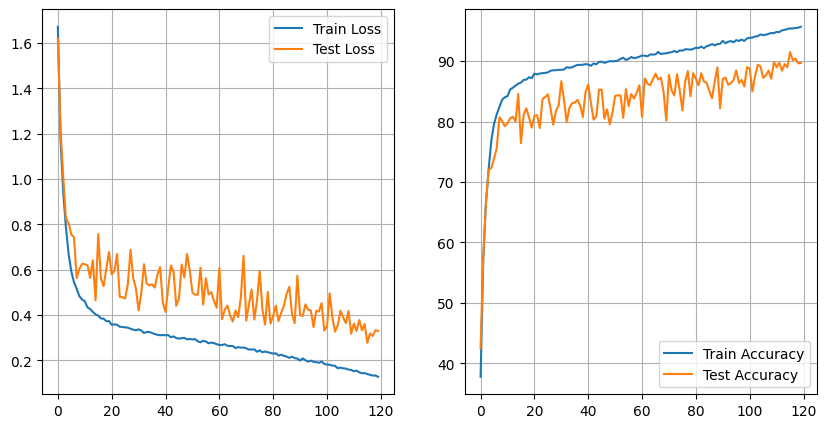

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
x_axis = range(len(history['loss']))
ax0.plot(x_axis, history['loss'], label='Train Loss')
ax0.plot(x_axis, history['test_loss'], label='Test Loss')
ax1.plot(x_axis, history['accuracy'], label='Train Accuracy')
ax1.plot(x_axis, history['test_accuracy'], label='Test Accuracy')
ax0.grid(True)
ax1.grid(True)
ax0.legend()
ax1.legend()
f.savefig("./trainTestCurve.png")

## Visualize the Predictions

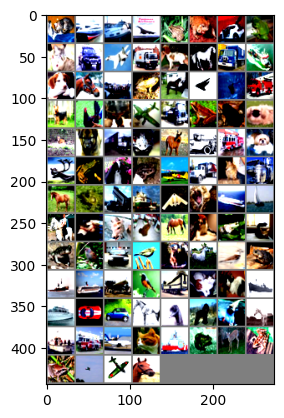

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Plot Confusion Matrix

In [ ]:
def get_predictions(model, iterator, device):
  ## Set model to evaluate mode 

  model.eval()
  
  ## Labels and probability lists 

  labels = []
  probs = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

In [ ]:
labels, probs = get_predictions(net, testloader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10, 10));
  ax = fig.add_subplot(1, 1, 1);
  cm = confusion_matrix(labels, pred_labels);
  cm = ConfusionMatrixDisplay(cm, display_labels = classes);
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 20)

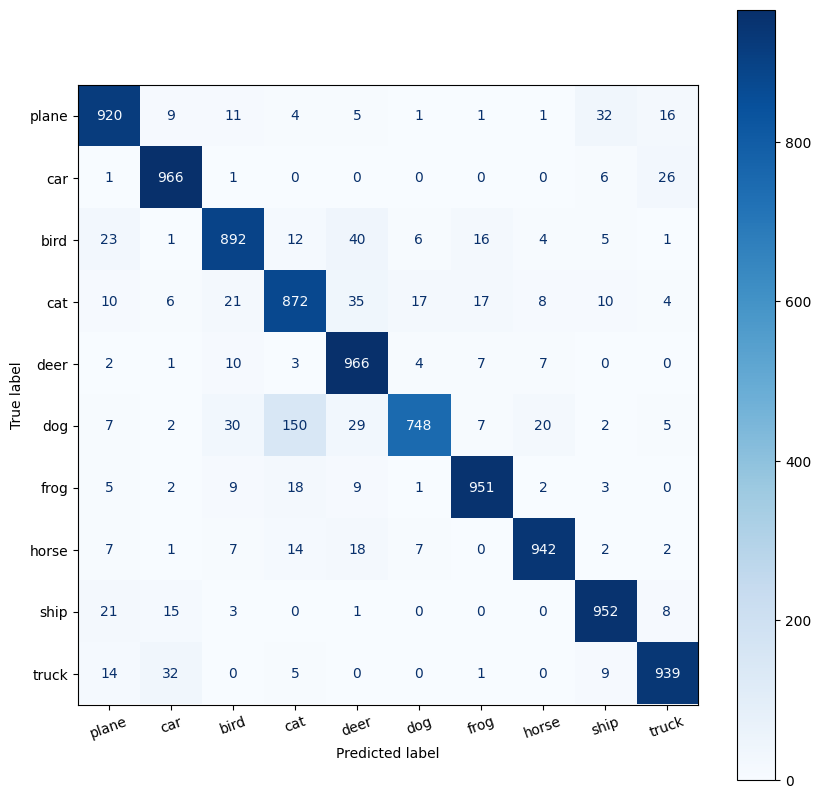

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)